In [1]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import csv
import string
import scipy
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img
from tensorflow.keras.applications import resnet, ResNet50,VGG16,ResNet101, VGG19
import cv2
import random
import shutil
import imutils
from PIL import Image

# Training, Validation, and Test Sub-directory setup

In [2]:
src_dir = './data/brain_tumor_dataset/'

In [3]:
# Set variable for sub-directories
yes_dir = os.path.join(src_dir, 'yes')
no_dir = os.path.join(src_dir, 'no')

# Get the list of all the images
yes_dir_content = os.listdir(yes_dir)
no_dir_content = os.listdir(no_dir)

# shuffle the data
random.shuffle(yes_dir_content)
random.shuffle(no_dir_content)

In [4]:
# split the data into training, validation and test sets for no folder
yes_training_idx = int(len(yes_dir_content) * 0.75)
yes_validation_idx = int(len(yes_dir_content) * 0.9)

# split the data into training, validation and test sets for yes folder
no_training_idx = int(len(no_dir_content) * 0.75)
no_validation_idx = int(len(no_dir_content) * 0.9)

# split the data into training, validation and test sets for yes folder
yes_training = yes_dir_content[:yes_training_idx]
yes_validation = yes_dir_content[yes_training_idx:yes_validation_idx]
yes_test = yes_dir_content[yes_validation_idx:]

no_training = no_dir_content[:no_training_idx]
no_validation = no_dir_content[no_training_idx:no_validation_idx]
no_test = no_dir_content[no_validation_idx:]

In [5]:
# List of subdirectories
subdirs = ['training', 'validation', 'test']

# Loop over each subdirectory
for subdir in subdirs:
    # Full path to the subdirectory
    dir_path = os.path.join(src_dir, subdir)
    
    # Check if the subdirectory exists
    if os.path.exists(dir_path):
        # If it does, remove it (and all its contents)
        print(f'Removing existing directory: {dir_path}')
        shutil.rmtree(dir_path)
    
    # Create the subdirectory
    os.mkdir(dir_path)


Removing existing directory: ./data/brain_tumor_dataset/training
Removing existing directory: ./data/brain_tumor_dataset/validation
Removing existing directory: ./data/brain_tumor_dataset/test


In [6]:
# Now let's copy the images into the directories
for subdir, data in zip(subdirs, [(yes_training, no_training), 
                                  (yes_validation, no_validation), 
                                  (yes_test, no_test)]):
    for label, label_data in zip(['yes', 'no'], data):
        # Create label specific subdirectory path
        label_dir = os.path.join(src_dir, subdir, label)

        # Create the label specific subdirectory
        os.mkdir(label_dir)

        # Copy each file to the right directory
        for filename in label_data:
            # The source file
            src_file = os.path.join(src_dir, label, filename)

            # The destination file
            dst_file = os.path.join(label_dir, filename)

            # Copy the file
            shutil.copy2(src_file, dst_file)

# Data Exploration & Preparation

ref: [finding-extreme-contours](https://pyimagesearch.com/2016/04/11/finding-extreme-points-in-contours-with-opencv/)

In [7]:
training_dir = os.path.join(src_dir, 'training')

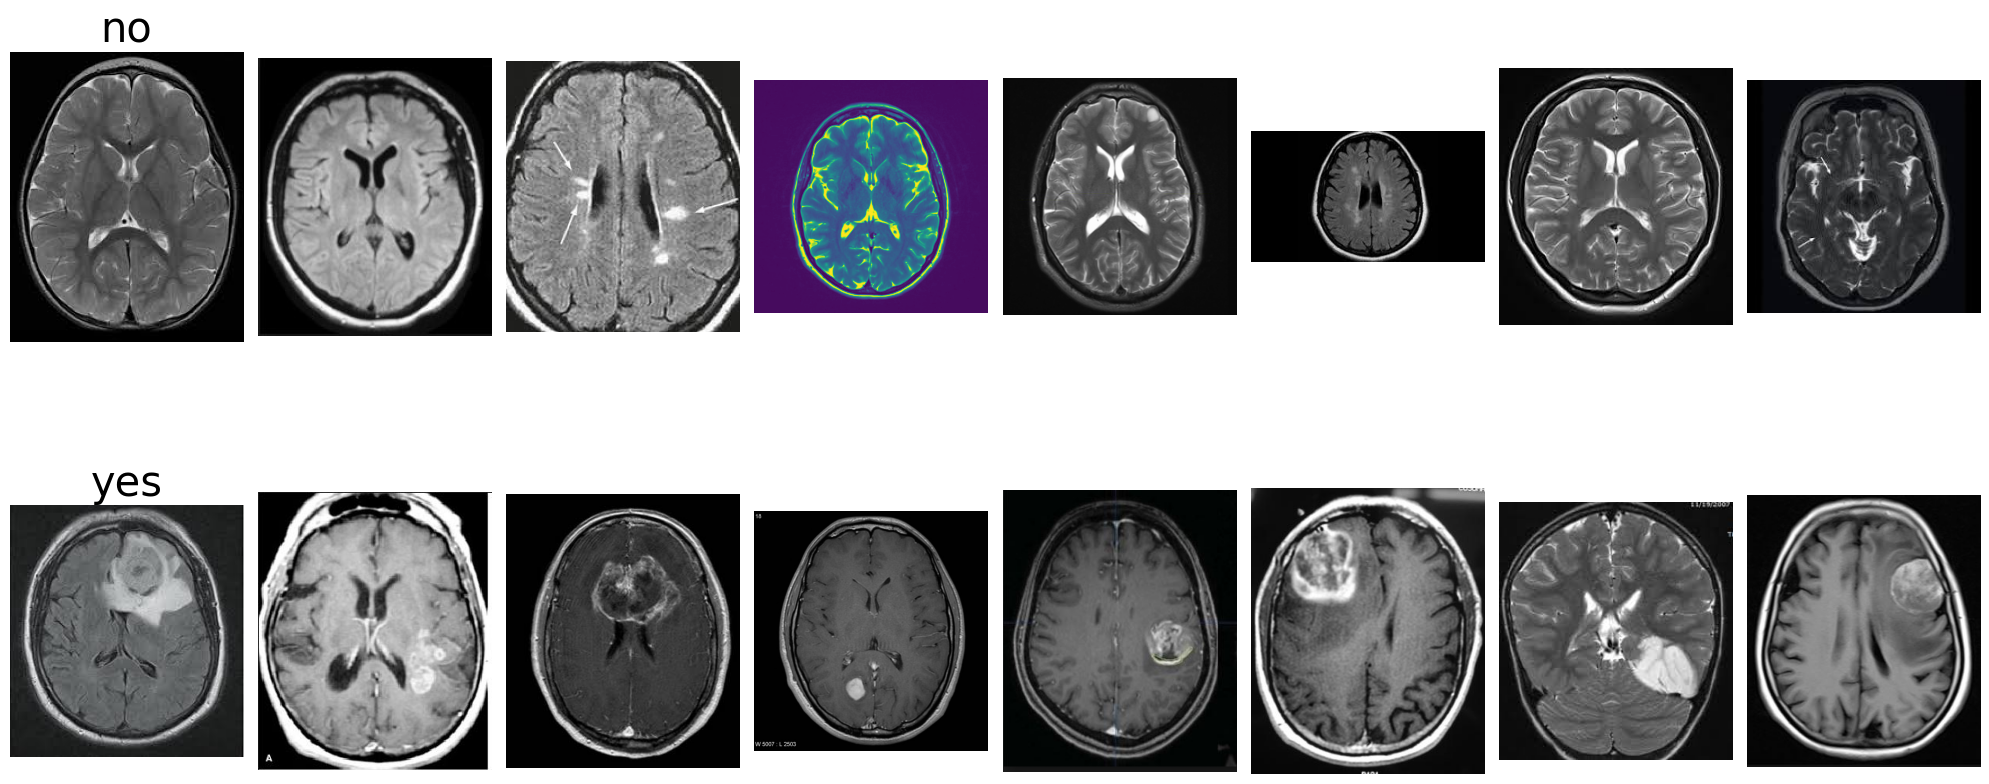

In [8]:
# Get a list of all subdirectories paths (each one is a class label)
subdirs = [os.path.join(training_dir, subdir) for subdir in os.listdir(training_dir)]

# Specify the number of columns for your plot
ncols = 8

# Set up matplotlib fig
fig, ax = plt.subplots(len(subdirs), ncols, figsize=(20, 10))

# For each subdirectory, select random images
for i, subdir in enumerate(subdirs):
    subdir_images = os.listdir(subdir) # Get list of dir contents
    random_image_names = random.sample(subdir_images, ncols) # Get a sample of dir content
    images = [os.path.join(subdir, img_name) for img_name in random_image_names] # Append path to each sample image
    
    for j, img_path in enumerate(images):
        # Set up subplot; subplot indices start at 1
        sp = ax[i, j]
        if j == 0:
            sp.set_title(os.path.basename(subdir), fontsize=30)  # set title to the first image of each row
        sp.axis('Off') # Don't show axes (or gridlines)

        img = mpimg.imread(img_path)
        sp.imshow(img) # Show random image

plt.tight_layout()
plt.show()

In [9]:
def visualize_transformations(img, debug_mode=False):
    """
    Applies transformations to the image and plots each step
    """
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Apply Gaussian blur
    gray_blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply threshold
    thresh = cv2.threshold(gray_blurred, 45, 255, cv2.THRESH_BINARY)[1]

    # Apply erosion and dilation
    thresh_eroded = cv2.erode(thresh, None, iterations=2)
    thresh_dilated = cv2.dilate(thresh_eroded, None, iterations=2)

    # Find contours
    cnts = cv2.findContours(thresh_dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)

    # Find the largest contour
    c = max(cnts, key=cv2.contourArea)

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # Crop the image
    PIXEL_PADDING = 0  # Adjust this value to your needs
    new_img = img[extTop[1]-PIXEL_PADDING:extBot[1]+PIXEL_PADDING, extLeft[0]-PIXEL_PADDING:extRight[0]+PIXEL_PADDING].copy()

    # If debug mode is enabled, plot the images
    if debug_mode:
        cnt_img = img.copy()

        # draw the outline of the object, then draw each of the
        # extreme points, where the left-most is red, right-most
        # is green, top-most is blue, and bottom-most is teal
        cv2.drawContours(cnt_img, [c], -1, (0, 255, 255), 2)
        cv2.circle(cnt_img, extLeft, 8, (0, 0, 255), -1)
        cv2.circle(cnt_img, extRight, 8, (0, 255, 0), -1)
        cv2.circle(cnt_img, extTop, 8, (255, 0, 0), -1)
        cv2.circle(cnt_img, extBot, 8, (255, 255, 0), -1)

        # Plot images
        fig, axs = plt.subplots(1, 7, figsize=(20, 20))
        axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axs[0].set_title('Original Image')
        axs[1].imshow(gray, cmap='gray')
        axs[1].set_title('Grayscale Image')
        axs[2].imshow(gray_blurred, cmap='gray')
        axs[2].set_title('Blurred Image')
        axs[3].imshow(thresh, cmap='gray')
        axs[3].set_title('Thresholded Image')
        axs[4].imshow(thresh_dilated, cmap='gray')
        axs[4].set_title('Dilated Image')
        axs[5].imshow(cv2.cvtColor(cnt_img, cv2.COLOR_BGR2RGB))
        axs[5].set_title('Contour Image')
        axs[6].imshow(cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB))
        axs[6].set_title('Cropped Image')

        for ax in axs:
            ax.axis('off')

    # If debug mode is not enabled, return the cropped image
    else:
        return new_img


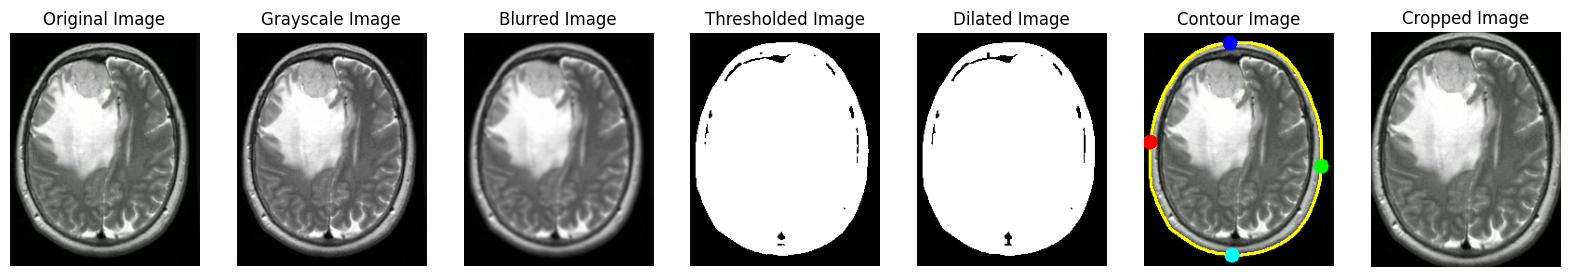

In [10]:
# Get the first image name from 'yes' directory
first_image_name = random.choice(os.listdir(os.path.join(src_dir, 'yes')))

# Get full path of the image
first_image_path = os.path.join(src_dir, 'yes', first_image_name)

# Now read the image
img = cv2.imread(first_image_path)

# Visualize the transformations
visualize_transformations(img, debug_mode=True)

In [11]:
def process_images(directory):
    """
    Apply transformations to all images in the specified directory.
    """
    # Get all file names in the directory
    for folder in os.listdir(directory):
        folder_path = os.path.join(directory, folder)
        filenames = os.listdir(folder_path)

        for filename in filenames:
            # Full path to the file
            file_path = os.path.join(folder_path, filename)

            # Read the image
            img = cv2.imread(file_path)

            # If the image was successfully read
            if img is not None:
                # Apply the transformations (without visualizing)
                transformed_img = visualize_transformations(img, debug_mode=False)

                # Overwrite the original image with the transformed image
                # OpenCV uses BGR color format, so we need to convert back from RGB
                transformed_img = cv2.cvtColor(transformed_img, cv2.COLOR_RGB2BGR)
                cv2.imwrite(file_path, transformed_img)
            else:
                print(f"Image {filename} could not be read")

# Path to the directories
train_dir = os.path.join(src_dir, 'training')
valid_dir = os.path.join(src_dir, 'validation')
test_dir = os.path.join(src_dir, 'test')

# Apply the function to each directory
process_images(train_dir)
process_images(valid_dir)
process_images(test_dir)


In [12]:
# set the paramters we want to change randomly
demo_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    brightness_range=[0.1, 1.5],
    horizontal_flip=True,
    vertical_flip=True
)

In [13]:
_preview_dir = './data/brain_tumor_dataset/preview'

if os.path.exists(_preview_dir):
    print("Removing existing directory: 'preview'")
    shutil.rmtree(_preview_dir)
os.mkdir(_preview_dir)

# load single image for example
x = img.reshape((1,) + img.shape) 

# create directory for augmented images
i = 0
for batch in demo_datagen.flow(x, batch_size=1, save_to_dir=_preview_dir, save_prefix='aug_img', save_format='jpg'):
    i += 1
    if i > 20:
        break 

Removing existing directory: 'preview'


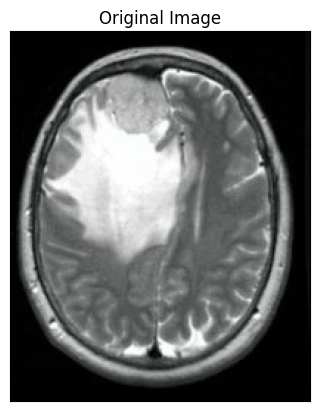

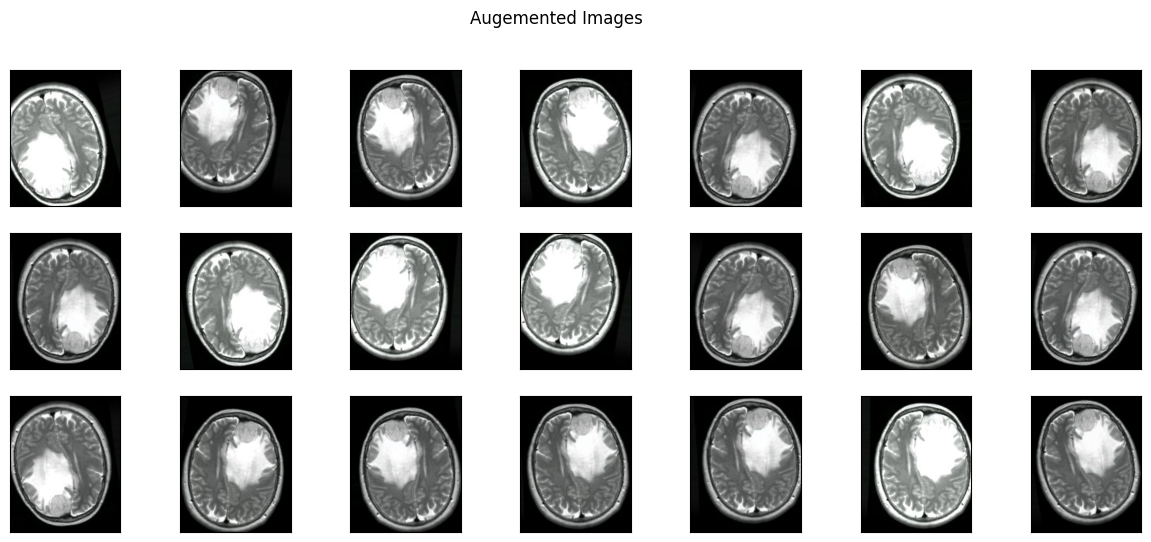

In [14]:
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.show()

plt.figure(figsize=(15,6))
i = 1
for img in os.listdir(_preview_dir):
    img = cv2.imread(os.path.join(_preview_dir, img))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3,7,i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i += 1
    if i > 3*7:
        break
plt.suptitle('Augemented Images')
plt.show()

# Data Generator

In [15]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input


pre_trained_model = VGG16(input_shape = (150, 150, 3), 
                          include_top = False, 
                          classifier_activation='sigmoid',
                          classes=1)

# Freeze the weights of the layers.
for layer in pre_trained_model.layers:
    layer.trainable = False


In [16]:
TRAIN_DIR = './data/brain_tumor_dataset/training'
VAL_DIR = './data/brain_tumor_dataset/validation'
IMG_SIZE = (150, 150)
CLASS_MODE = 'binary'

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)


train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode=CLASS_MODE,
    classes=['no', 'yes'],
    shuffle=False,
)


validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode=CLASS_MODE,
    classes=['no', 'yes'],
    shuffle=False
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary',
        shuffle=False)

Found 189 images belonging to 2 classes.
Found 38 images belonging to 2 classes.
Found 26 images belonging to 2 classes.


In [17]:
EPOCHS = 30
myCallback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    mode='min',
    patience=6,
    restore_best_weights=True
)

In [18]:
model = tf.keras.Sequential([
    pre_trained_model,  # Pretrained base
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dropout (Dropout)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 1)                 8193      
                                                                 
Total params: 14722881 (56.16 MB)
Trainable params: 8193 (32.00 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [20]:
history = model.fit(train_generator, epochs=30, validation_data=validation_generator, verbose=1, callbacks=[myCallback])

Epoch 1/30
6/6 [==============================] - 7s 1s/step - loss: 7.3530 - acc: 0.5185 - val_loss: 4.2607 - val_acc: 0.6842
Epoch 2/30
6/6 [==============================] - 6s 1s/step - loss: 7.1080 - acc: 0.6455 - val_loss: 3.7016 - val_acc: 0.7368
Epoch 3/30
6/6 [==============================] - 6s 1s/step - loss: 5.0626 - acc: 0.6825 - val_loss: 1.4679 - val_acc: 0.8158
Epoch 4/30
6/6 [==============================] - 6s 1s/step - loss: 3.4331 - acc: 0.7090 - val_loss: 1.3884 - val_acc: 0.7895
Epoch 5/30
6/6 [==============================] - 6s 1s/step - loss: 2.6851 - acc: 0.7619 - val_loss: 0.6243 - val_acc: 0.9211
Epoch 6/30
6/6 [==============================] - 6s 1s/step - loss: 2.8436 - acc: 0.7354 - val_loss: 0.6876 - val_acc: 0.8947
Epoch 7/30
6/6 [==============================] - 6s 1s/step - loss: 2.3246 - acc: 0.7513 - val_loss: 0.8209 - val_acc: 0.9211
Epoch 8/30
6/6 [==============================] - 6s 1s/step - loss: 2.2083 - acc: 0.7831 - val_loss: 1.0031 - 

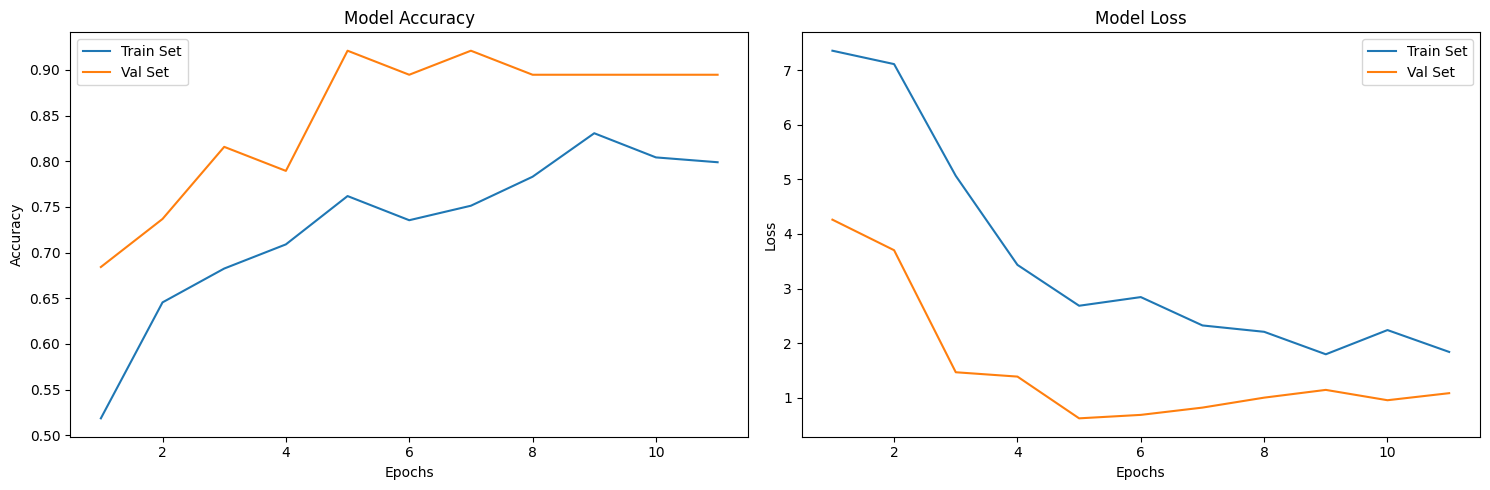

In [21]:
# plot model performance
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

# Evaluations


## Eval (Val)

In [22]:
def metrics2dt(acc, rc, pr, f1):
    return pd.DataFrame(data={"Accuracy":acc, "Recall":rc, "Precision":pr, "F1-Score":f1}, index=[0])

def show_metrics(y_true, y_pred):
    recall = tf.keras.metrics.Recall()
    precision = tf.keras.metrics.Precision()
    accuracy = tf.keras.metrics.Accuracy()

    recall.update_state(y_true, y_pred)
    recall = recall.result().numpy()
    
    precision.update_state(y_true, y_pred)
    precision = precision.result().numpy()
    
    accuracy.update_state(y_true, y_pred)
    accuracy = accuracy.result().numpy()
    
    f1_score = 0
    if recall+precision != 0:
        f1_score = 2 * ((recall*precision)/(recall+precision))
    
    return metrics2dt(accuracy, recall, precision, f1_score)

3/3 [==============================] - 1s 290ms/step


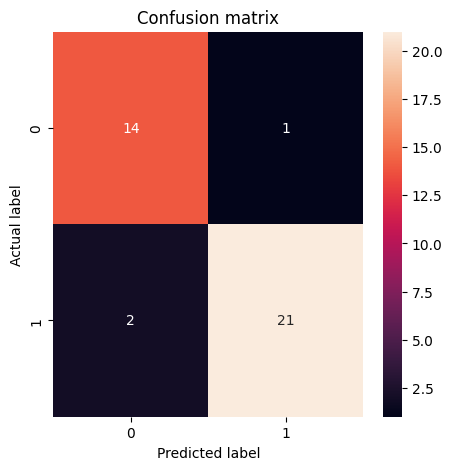

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# Assuming that you have the true labels
true_labels = validation_generator.classes

# Get the predicted probabilities from the model
predicted_probs = history.model.predict(validation_generator, steps=len(validation_generator))

# Convert probabilities to class labels: if you're working on a binary classification problem
predicted_labels = [1 if prob > 0.5 else 0 for prob in predicted_probs]

# If you're working on a multi-class classification problem, use argmax
# predicted_labels = np.argmax(predicted_probs, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot it using seaborn
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()


In [24]:
show_metrics(true_labels, predicted_labels)

,Accuracy,Recall,Precision,F1-Score
0,0.921053,0.913043,0.954545,0.933333


## Eval (Test)

In [25]:
loss, accuracy = model.evaluate(test_generator, steps=len(test_generator))

2/2 [==============================] - 1s 164ms/step - loss: 2.2443 - acc: 0.8077


2/2 [==============================] - 1s 163ms/step


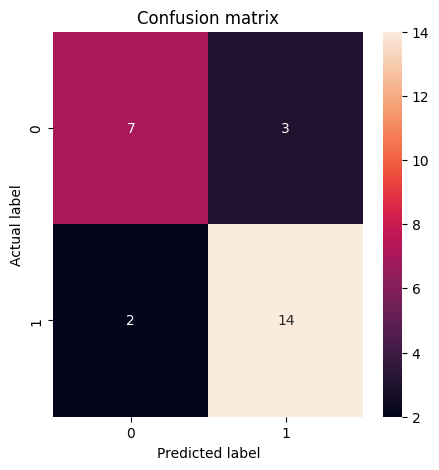

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# Assuming that you have the true labels
true_labels = test_generator.classes

# Get the predicted probabilities from the model
predicted_probs = history.model.predict(test_generator, steps=len(test_generator))

# Convert probabilities to class labels: if you're working on a binary classification problem
predicted_labels = [1 if prob > 0.5 else 0 for prob in predicted_probs]

# If you're working on a multi-class classification problem, use argmax
# predicted_labels = np.argmax(predicted_probs, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot it using seaborn
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()


In [27]:
show_metrics(true_labels, predicted_labels)

,Accuracy,Recall,Precision,F1-Score
0,0.807692,0.875,0.823529,0.848485
